# Visualisation of SOTA results

load and preprocess dataset

In [ ]:
# from fco2models.utraining import prep_df
# import pandas as pd
# import xarray as xr
# import numpy as np

# def add_xco2(df):
#     selector = df[['lat_005', 'time_1d']].to_xarray()
#     # rename the columns to match the xarray dataset
#     selector = selector.rename({'lat_005': 'lat', 'time_1d': 'time'})
#     xco2mbl = xr.open_dataarray('../data/atmco2/xco2mbl-timeP7D_1D-lat25km.nc')
#     matched_xco2 = xco2mbl.sel(**selector, method='nearest').to_series()
    
#     df['xco2'] = matched_xco2

#     return df 

# dfs = []
# for year in range(1982, 2022):
#     df = pd.read_parquet(f'../data/SOCATv2024-1d_005deg-colloc-r20250224/SOCATv2024_1d_005deg_collocated_{year}-r20250224.pq')
#     df.reset_index(inplace=True)
#     df['year'] = year
#     df = add_xco2(df)
#     dfs.append(df)

# df = pd.concat(dfs, ignore_index=True)
# #add day_of_year column
# df['day_of_year'] = df['time_1d'].dt.dayofyear
# # renane lon and lat columns
# df = df.rename(columns={'lon_005':'lon', 'lat_005': 'lat'})
# # df['chl_globcolour'] = np.log(df['chl_globcolour'].clip(1e-5, None))
# # df['mld_dens_soda'] = np.log(df['mld_dens_soda'].clip(1e-5, None))
# df = prep_df(df, bound=True)[0]

2025-06-03 13:57:53,140 - INFO - salinity stacking
2025-06-03 13:57:53,181 - INFO - adding positional and temporal encodings
2025-06-03 13:57:54,312 - INFO - add climatology data
2025-06-03 13:58:10,413 - INFO - removing xco2 levels from fco2rec_uatm
2025-06-03 13:58:10,436 - INFO - replacing outliers with Nans, fco2rec_uatm > 400


In [1]:
import pandas as pd
import numpy as np
from fco2models.utraining import prep_df, make_monthly_split, get_segments_random, get_segments, get_context_mask, normalize_dss, get_stats_df
DATA_PATH = "../data/training_data/"
df = pd.read_parquet(DATA_PATH + "SOCAT_1982_2021_grouped_colloc_augm_bin.pq", engine='pyarrow')
df = prep_df(df, bound=True)[0]
#map expocode column to int
expocode_map = df['expocode'].unique()
expocode_map = {expocode: i for i, expocode in enumerate(expocode_map)}
df['expocode_id'] = df['expocode'].map(expocode_map) 
print(df.columns)

2025-06-03 14:27:09,723 - INFO - salinity stacking
2025-06-03 14:27:09,804 - INFO - adding positional and temporal encodings
2025-06-03 14:27:12,072 - INFO - add climatology data
2025-06-03 14:27:27,688 - INFO - adding xco2 data
2025-06-03 14:27:30,577 - INFO - removing xco2 levels from fco2rec_uatm
2025-06-03 14:27:30,609 - INFO - replacing outliers with Nans, fco2rec_uatm > 400


Index(['index', 'expocode', 'window_id', 'time_1d', 'lat', 'lon', 'sal',
       'sst_deg_c', 'pppp_hpa', 'woa_sss', 'ncep_slp_hpa', 'dist_to_land_km',
       'fco2rec_uatm', 'fco2rec_flag', 'time', 'year', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'lon_soda', 'lat_soda', 'depth_soda',
       'time_soda', 'sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sstcci',
       'lat_sstcci', 'lon_sstcci', 'interpolated', 'bin_id', 'segment_id',
       'ssh_adt', 'ssh_sla', 'lat_sshcm', 'lon_sshcm', 'time_sshcm',
       'chl_globcolour', 'chl_globcolour_uncert', 'chl_globcolour_flags',
       'time_chlgc', 'lat_chlgc', 'lon_chlgc', 'sss_cci',
       'sss_cci_random_error', 'lat_ssscci', 'lon_ssscci', 'time_ssscci',
       'day_of_year', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat',
       'sin_lon_cos_lat', 'cos_lon_cos_lat', 'sin_lon', 'cos_lon', 'is_north',
       'co2_clim8d', 'xco2', 'expocode_id'],
      dtype='object')


In [2]:
df.columns

Index(['index', 'expocode', 'window_id', 'time_1d', 'lat', 'lon', 'sal',
       'sst_deg_c', 'pppp_hpa', 'woa_sss', 'ncep_slp_hpa', 'dist_to_land_km',
       'fco2rec_uatm', 'fco2rec_flag', 'time', 'year', 'temp_soda',
       'salt_soda', 'mld_dens_soda', 'lon_soda', 'lat_soda', 'depth_soda',
       'time_soda', 'sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sstcci',
       'lat_sstcci', 'lon_sstcci', 'interpolated', 'bin_id', 'segment_id',
       'ssh_adt', 'ssh_sla', 'lat_sshcm', 'lon_sshcm', 'time_sshcm',
       'chl_globcolour', 'chl_globcolour_uncert', 'chl_globcolour_flags',
       'time_chlgc', 'lat_chlgc', 'lon_chlgc', 'sss_cci',
       'sss_cci_random_error', 'lat_ssscci', 'lon_ssscci', 'time_ssscci',
       'day_of_year', 'sin_day_of_year', 'cos_day_of_year', 'sin_lat',
       'sin_lon_cos_lat', 'cos_lon_cos_lat', 'sin_lon', 'cos_lon', 'is_north',
       'co2_clim8d', 'xco2', 'expocode_id'],
      dtype='object')

In [3]:
# remove entries with high ice concentration
#df = df[df.ice_cci < 0.8]

load the model

In [12]:
import json
from fco2models.ueval import load_models, print_loss_info
from fco2models.umeanest import MLPModel

save_dir = '../models/sota/'
model_path = 'e_30.pt'
model_name = 'sota_mlp'
model_info = {
    model_name: [save_dir, model_path, MLPModel]
    }

models = load_models(model_info)
train_loss = models['sota_mlp']['losses']['train_losses']
val_loss = models['sota_mlp']['losses']['val_losses']
model_info = models['sota_mlp']


In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from fco2models.umeanest import predict_mean_eval, get_loader_point_ds
from fco2models.utraining import normalize_dss

params = model_info['params']
predictors = params['predictors']

train_stats = dict([
    ('means', params['train_means']),
    ('stds', params['train_stds']),
    ('mins', params['train_mins']),
    ('maxs', params['train_maxs'])
              ])

mode = params['mode']
model = model_info['model']
target = 'fco2rec_uatm'

cols = [target] + predictors
df_clean = df[cols].dropna()
dataloader = get_loader_point_ds(df_clean, train_stats, mode)
_, preds = predict_mean_eval(model, dataloader, is_sequence=False)

2025-06-03 14:28:13,173 - INFO - Using given stats for normalization
2025-06-03 14:28:13,182 - INFO - Normalizing data using mean_std normalization
2025-06-03 14:28:13,182 - INFO - Not normalizing features: []


Predicting on cuda


Predicting: 100%|██████████| 2092/2092 [00:33<00:00, 61.57it/s, Loss=1.05]   


In [4]:
models=None
model=None
#df_clean=None
dataloader=None

In [5]:
test_months = pd.date_range('1982-01', '2022-01', freq='7MS').values.astype('datetime64[M]')
months = df.time_1d.values.astype('datetime64[M]')
mask_test = np.isin(months, test_months)

add predictions to original dataframe

In [8]:
df_clean['predictions'] = preds.squeeze(-1)
df.loc[df_clean.index, 'predictions'] = df_clean['predictions'] * train_stats['stds'][0] + train_stats['means'][0]
df['residuals'] = df['fco2rec_uatm'] - df['predictions']
group_cols = ['lat', 'lon']
df['lat'] = np.round(df['lat']*4, 0) / 4  # Round to 0.25 degrees for coarsening
df['lon'] = np.round(df['lon']*4, 0) / 4  # Round to 0.25 degrees for coarsening
plotting_data = (
    df.loc[:, group_cols + ['predictions', 'fco2rec_uatm', 'residuals']]
    .groupby(group_cols)
    .mean()
    .to_xarray()
    .coarsen(lat=1, lon=1, boundary='pad')
    .mean())

(np.float64(-180.125),
 np.float64(180.125),
 np.float64(-78.875),
 np.float64(90.125))

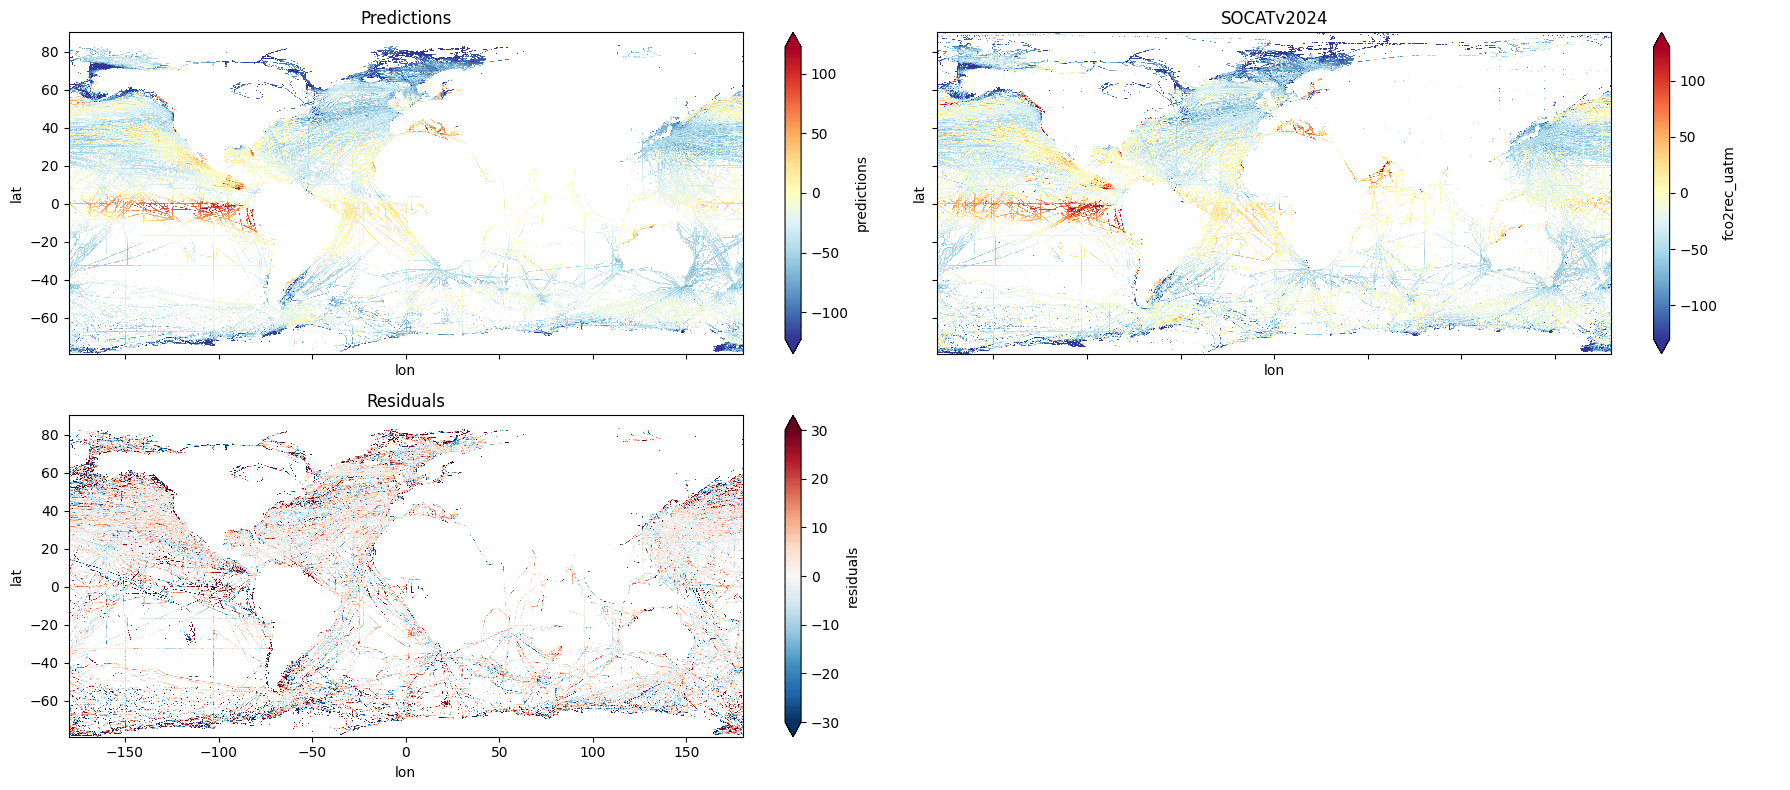

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
plotting_data.predictions.plot.imshow(robust=True, ax=axs[0, 0], cmap='RdYlBu_r',)
axs[0, 0].set_title('Predictions')
plotting_data.fco2rec_uatm.plot.imshow(robust=True, ax=axs[0, 1], cmap='RdYlBu_r')
axs[0, 1].set_title('SOCATv2024')
plotting_data.residuals.plot.imshow(robust=True, ax=axs[1, 0], cmap='RdBu_r', vmin=-30, vmax=30)
axs[1, 0].set_title('Residuals')

plt.tight_layout()
axs[1, 1].axis('off')

In [9]:
mask_test.shape

(6651249,)

In [10]:
# import rmse 
from sklearn.metrics import root_mean_squared_error
# import r2_score
from sklearn.metrics import r2_score
def get_error_stats(df):
    nan_mask = df['predictions'].isna()
    rmse = root_mean_squared_error(df.loc[~nan_mask, 'fco2rec_uatm'], df.loc[~nan_mask, 'predictions'])
    print(f'RMSE: {rmse:.2f}')
    r2 = r2_score(df.loc[~nan_mask, 'fco2rec_uatm'], df.loc[~nan_mask, 'predictions'])
    print(f'R2: {r2:.2f}')
    # bias
    bias = np.nanmean(df.loc[~nan_mask, 'residuals'])
    print(f'Bias: {bias:.2f}')

In [11]:
print("train errors:")
get_error_stats(df.loc[~mask_test])
print("test errors:")
get_error_stats(df.loc[mask_test])

train errors:


: 

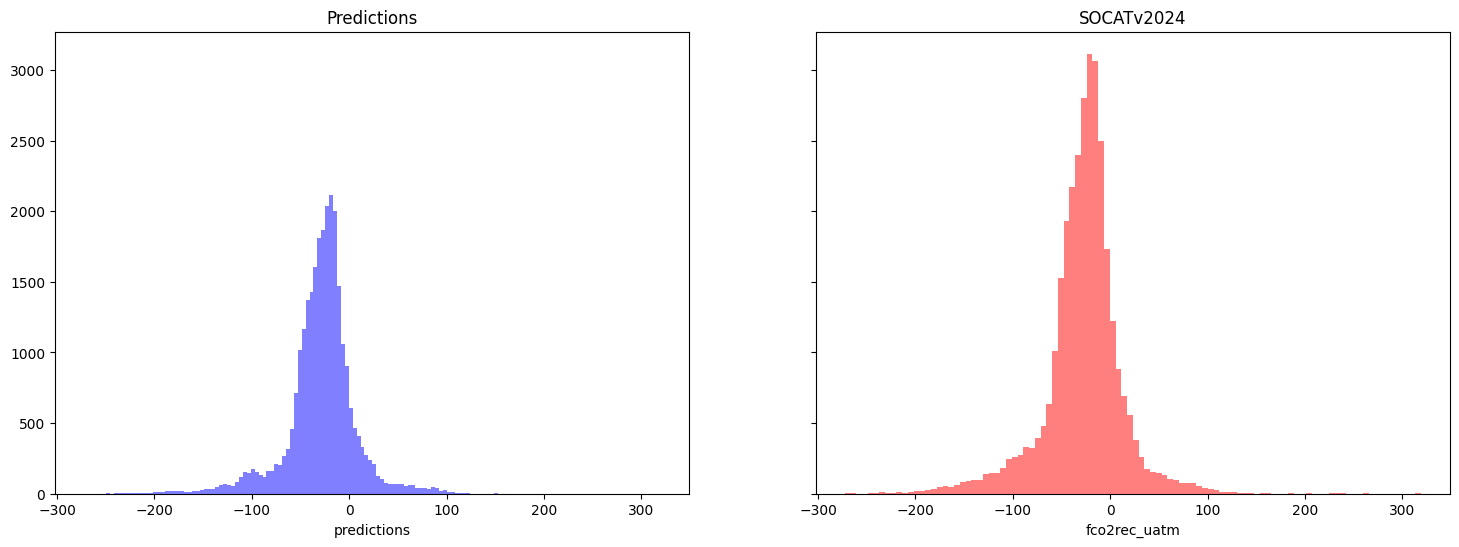

In [11]:
# plot histogramns of predictions and fco2rec_uatm
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
plotting_data.predictions.plot.hist(ax=axs[0], bins=100, color='blue', alpha=0.5, label='predictions')
axs[0].set_title('Predictions')
plotting_data.fco2rec_uatm.plot.hist(ax=axs[1], bins=100, color='red', alpha=0.5, label='fco2rec_uatm')
axs[1].set_title('SOCATv2024')
plt.show()

In [10]:
from sklearn import metrics
def plot_line_comparison(ax, y, yhat, **kwargs):
    from scipy.stats import pearsonr

    y.plot(ax=ax, **(kwargs | dict(label='SOCAT')))
    yhat.plot(ax=ax, **kwargs)
    
    m = y.notnull() & yhat.notnull()
    y = y[m]
    yhat = yhat[m]
    
    metric_txt = (
        f"r2 = {metrics.r2_score(y, yhat):.2f}"
        f"\nRMSE = {metrics.root_mean_squared_error(y, yhat):.1f}"
        f"\nBias = {(yhat - y).mean():.1f}"
        f"\nPearson R = {pearsonr(y, yhat)[0]:.2f}")
    
    ax.text(0.01, 0.04, metric_txt, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom')
    
    ax.legend()

In [9]:
cruise_idx = 831

expocode = df.expocode[mask_test].value_counts().index[cruise_idx]
df_cruise = df[df.expocode == expocode].dropna(subset=['predictions', 'fco2rec_uatm'])

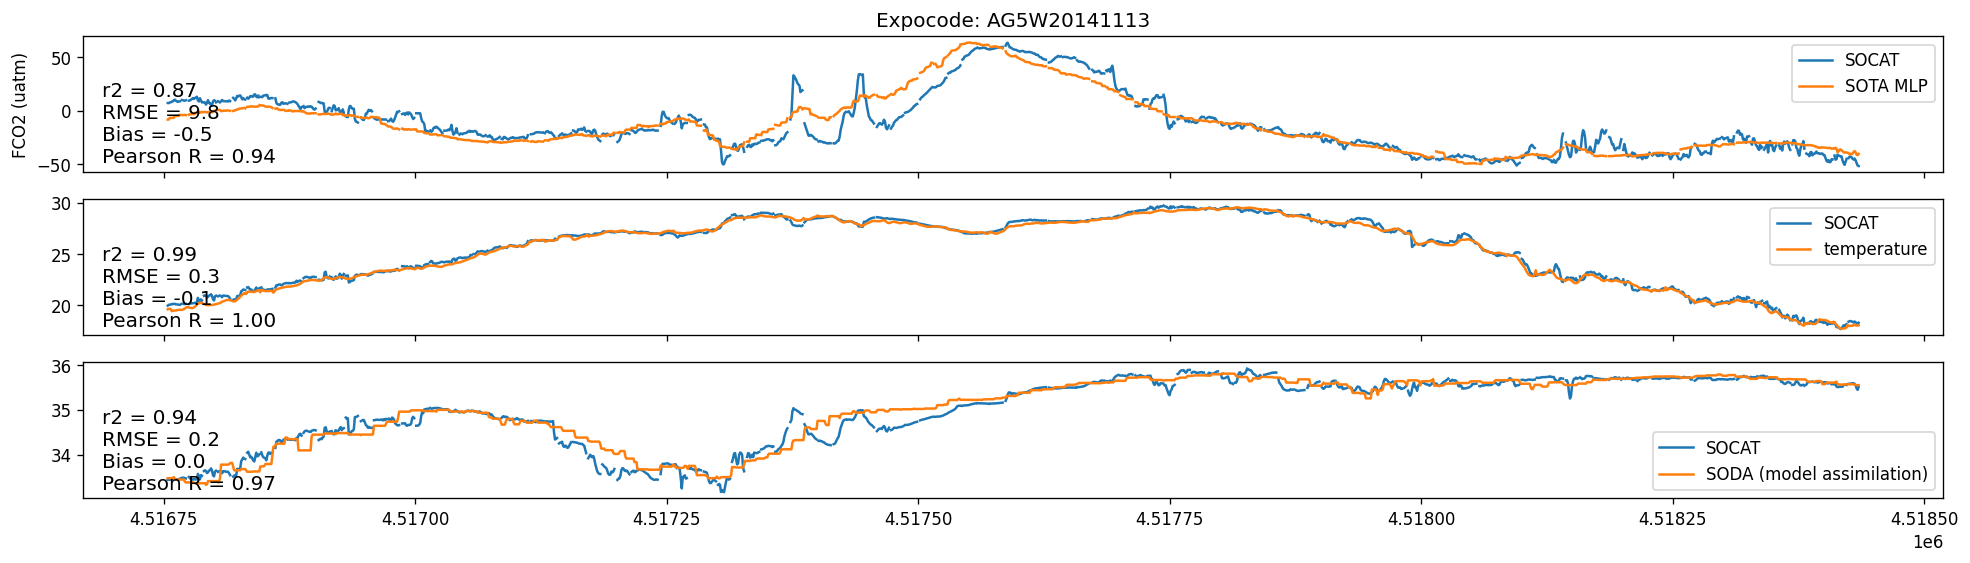

In [11]:
#cruise_idx = 831
import matplotlib.pyplot as plt

# expocode = df.expocode[mask_test].value_counts().index[cruise_idx]
expocode = 'AG5W20141113'
df_cruise = df[df.expocode == expocode]#.dropna(subset=['predictions', 'fco2rec_uatm'])

fig, axs = plt.subplots(3, 1, figsize=(20, 5), sharex=True, sharey=False, dpi=120)

axs[0].set_title(f'Expocode: {expocode}')
axs[0].set_ylabel('FCO2 (uatm)')
plot_line_comparison(axs[0], df_cruise.fco2rec_uatm, df_cruise.predictions, label='SOTA MLP')
plot_line_comparison(axs[1], df_cruise.sst_deg_c, df_cruise.sst_cci-273.15, label='temperature')
plot_line_comparison(axs[2], df_cruise.sal, df_cruise.salt_soda, label='SODA (model assimilation)')

global inference with sota model

In [6]:
import numpy as np
import pandas as pd
from fco2dataset.ucollocate import get_day_data, collocate
from fco2models.utraining import prep_df
def get_day_dataset(date):
    # get global satellite data for a given date
    dss = get_day_data(date, save_path='../data/inference/gridded')
    return dss

def collocate_coords(df, dss, date):
    save_path = '../data/inference/collocated'
    df_collocated = collocate(df, date, save_path=save_path, dss=dss, verbose=False)
    return df_collocated


lat_grid = np.linspace(-90, 90, int((90 - -90) / 0.25) + 1)
lon_grid = np.linspace(0, 360, int((360 - 0) / 0.25) + 1)
print(len(lat_grid), len(lon_grid))
grid_df = pd.DataFrame({
    'lat': np.repeat(lat_grid, len(lon_grid)),
    'lon': np.tile(lon_grid, len(lat_grid))
})
print(grid_df.shape)
print(grid_df.duplicated(subset=['lat', 'lon']).sum())
date = pd.Timestamp('2022-10-04')


dss = get_day_dataset(date)
df_collocated = collocate_coords(grid_df, dss, date)
print(df_collocated.duplicated(subset=['lat', 'lon']).sum())
df_collocated['time_1d'] = date
df_collocated = prep_df(df_collocated, with_target=False)[0]
print(df_collocated.duplicated(subset=['lat', 'lon']).sum())

721 1441
(1038961, 2)
0
All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/sss_multiobs.nc
Reading sst_cci data from ../data/inference/gridded_2022-10-04/sst_cci.

2025-06-03 16:16:41,737 - INFO - salinity stacking
2025-06-03 16:16:41,743 - INFO - adding positional and temporal encodings
2025-06-03 16:16:41,891 - INFO - add climatology data


0


2025-06-03 16:16:49,216 - INFO - adding xco2 data


721


In [7]:
lon_grid

array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5950e+02, 3.5975e+02,
       3.6000e+02], shape=(1441,))

In [8]:
from fco2models.ueval import load_models, print_loss_info
from fco2models.umeanest import MLPModel

save_dir = '../models/sota/'
model_path = 'e_30.pt'
model_name = 'sota_mlp'
model_info = {
    model_name: [save_dir, model_path, MLPModel]
    }

models = load_models(model_info)
train_loss = models['sota_mlp']['losses']['train_losses']
val_loss = models['sota_mlp']['losses']['val_losses']
model_info = models['sota_mlp']


In [9]:
import numpy as np
from fco2models.umeanest import predict_mean_eval, get_loader_point_ds

params = model_info['params']
predictors = params['predictors']

train_stats = dict([
    ('means', params['train_means']),
    ('stds', params['train_stds']),
    ('mins', params['train_mins']),
    ('maxs', params['train_maxs'])
              ])

mode = params['mode']
model = model_info['model']
target = 'fco2rec_uatm'

cols = [target] + predictors
df_collocated[target] = np.nan  # Initialize target column
dataloader = get_loader_point_ds(df_collocated[cols], train_stats, mode, dropna=False)
_, preds = predict_mean_eval(model, dataloader, is_sequence=False)

2025-06-03 16:17:23,367 - INFO - Using given stats for normalization
2025-06-03 16:17:23,369 - INFO - Normalizing data using mean_std normalization
2025-06-03 16:17:23,369 - INFO - Not normalizing features: []


Predicting on cuda


Predicting: 100%|██████████| 508/508 [00:07<00:00, 71.88it/s, Loss=nan]


In [10]:
df_collocated['predictions'] = preds.squeeze(-1)
df_collocated = df_collocated.groupby(['lat', 'lon']).mean()
ds = df_collocated.to_xarray()

In [11]:
ds

<xarray.Dataset> Size: 320MB
Dimensions:                (lat: 721, lon: 1440)
Coordinates:
  * lat                    (lat) float64 6kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * lon                    (lon) float64 12kB -180.0 -179.8 ... 179.5 179.8
Data variables: (12/52)
    level_0                (lat, lon) float64 8MB 720.0 721.0 ... 1.038e+06
    index                  (lat, lon) float64 8MB 720.0 721.0 ... 1.038e+06
    time                   (lat, lon) datetime64[s] 8MB 2022-10-04 ... 2022-1...
    chl_globcolour         (lat, lon) float32 4MB nan nan nan ... nan nan nan
    chl_globcolour_uncert  (lat, lon) float32 4MB nan nan nan ... nan nan nan
    chl_globcolour_flags   (lat, lon) float64 8MB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    ...                     ...
    cos_lon                (lat, lon) float64 8MB -1.0 -1.0 -1.0 ... -1.0 -1.0
    is_north               (lat, lon) float64 8MB 0.0 0.0 0.0 ... 1.0 1.0 1.0
    co2_clim8d             (lat, lon) float32 4MB nan nan nan ... -29.92 -29.91
    xco2                   (lat, lon) float64 8MB 415.7 415.7 ... 413.5 413.5
    fco2rec_uatm           (lat, lon) float64 8MB nan nan nan ... nan nan nan
    predictions            (lat, lon) float32 4MB nan nan nan ... nan nan nan

In [13]:
lon_min = -71
lon_max = -35
lat_min = -56
lat_max = -11

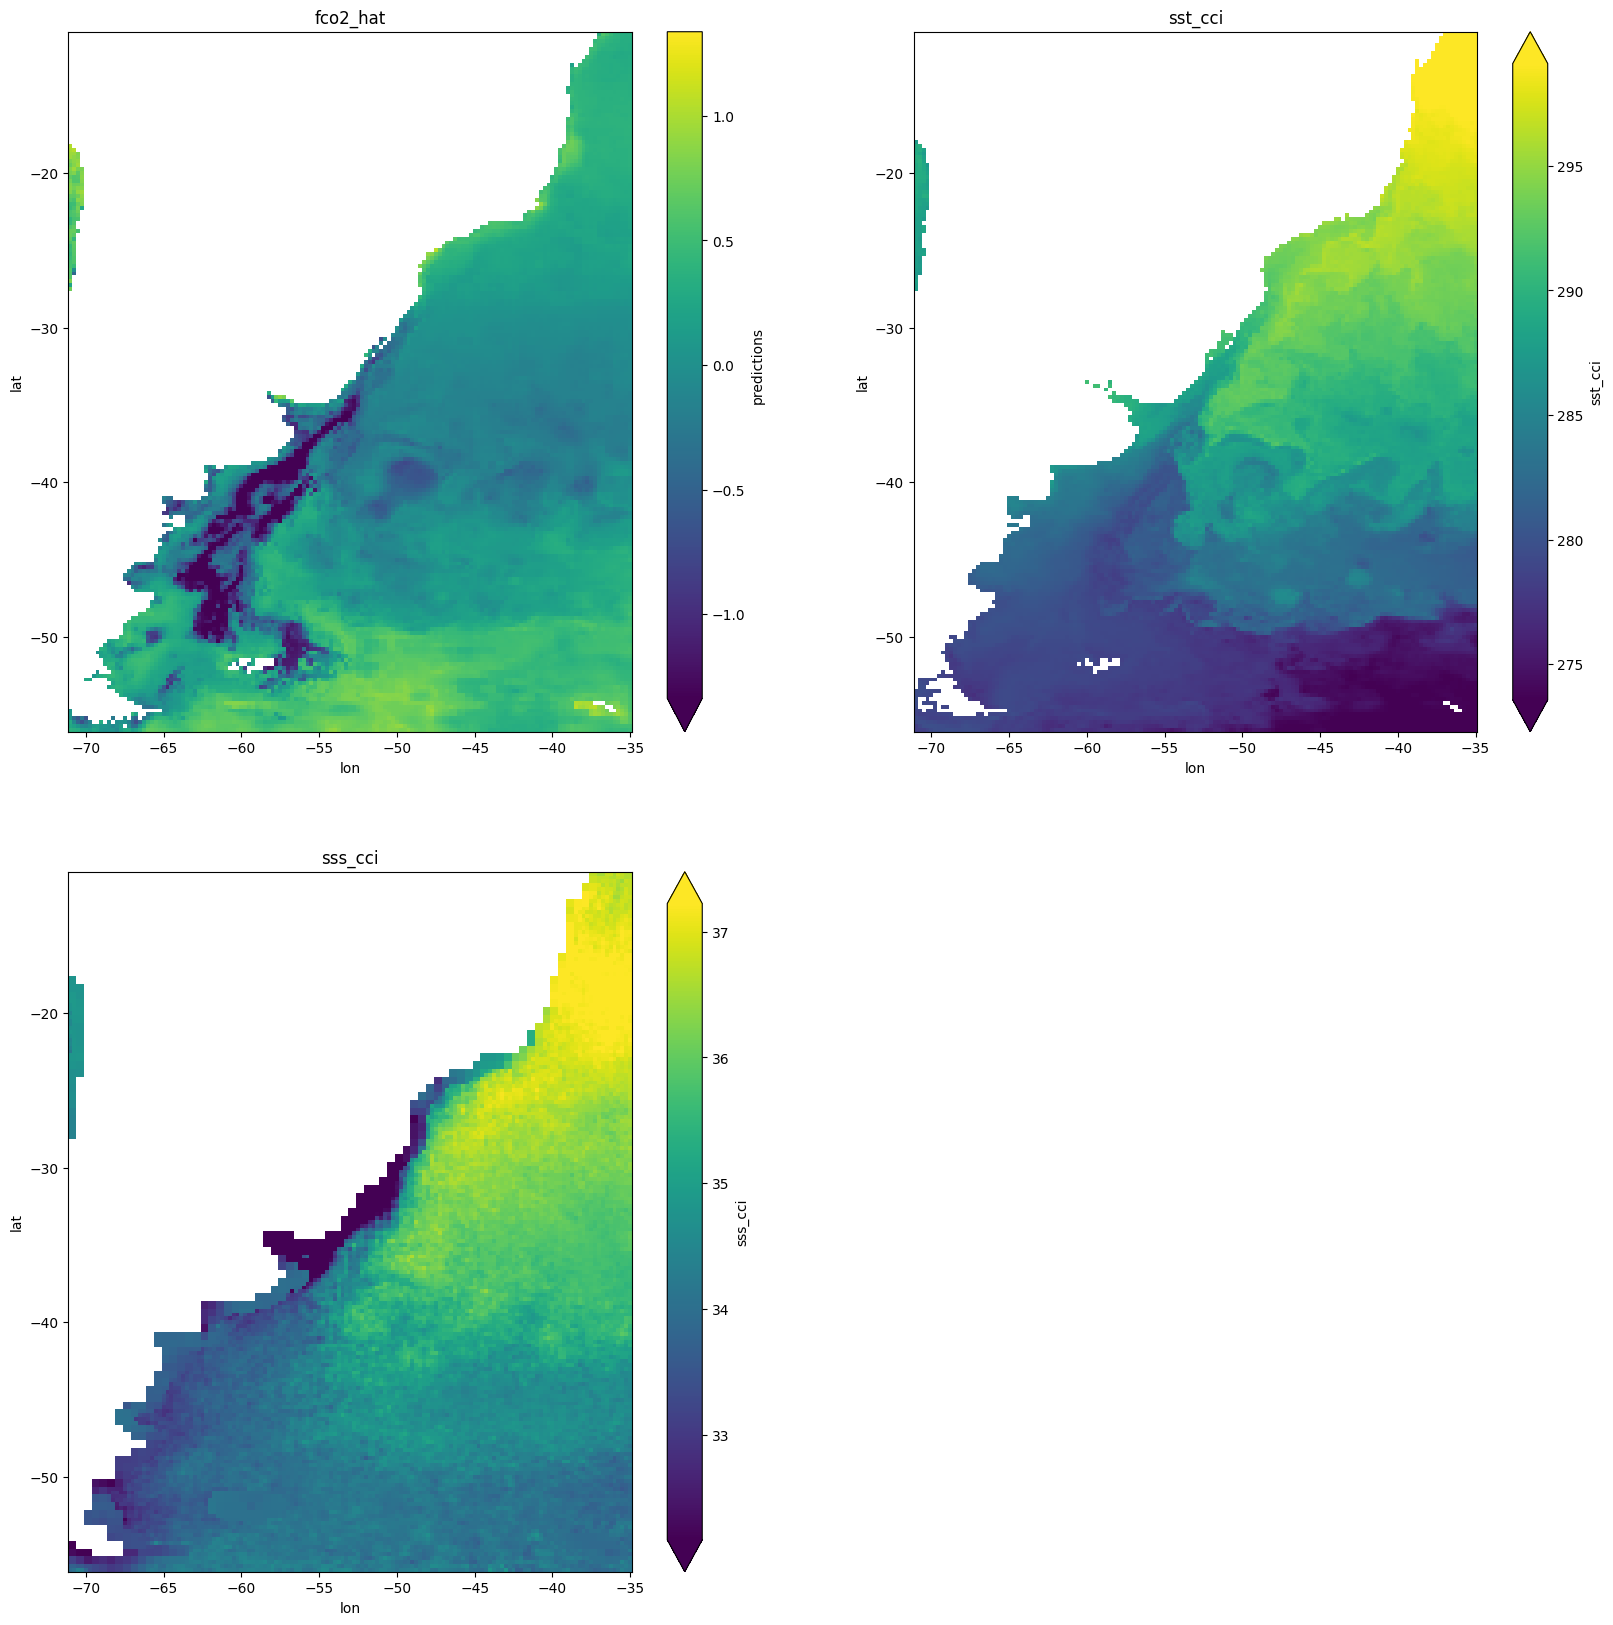

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(20, 20))
plot_ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
plot_ds.predictions.plot(ax=axs[0, 0], robust=True, cmap="viridis")
axs[0, 0].set_title("fco2_hat")
plot_ds.sst_cci.plot(ax=axs[0, 1], robust=True, cmap="viridis")
axs[0, 1].set_title("sst_cci")
plot_ds.sss_cci.plot(ax=axs[1, 0], robust=True, cmap="viridis")
axs[1, 0].set_title("sss_cci")
axs[1,1].set_visible(False)
plt.show()